In [133]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import pickle
from geopy.distance import vincenty

#### Analysis of Mobile Data using Accel Data

In [49]:
accel = pd.read_csv('accel_combined.csv')

In [18]:
accel_simran = pd.read_csv("accel_simran.csv")

In [3]:
accel.shape

(5573933, 29)

In [4]:
accel.columns

Index(['Unnamed: 0', 'diffSecs', 'N.samples', 'x.mean', 'x.absolute.deviation',
       'x.standard.deviation', 'x.max.deviation', 'x.PSD.1', 'x.PSD.3',
       'x.PSD.6', 'x.PSD.10', 'y.mean', 'y.absolute.deviation',
       'y.standard.deviation', 'y.max.deviation', 'y.PSD.1', 'y.PSD.3',
       'y.PSD.6', 'y.PSD.10', 'z.mean', 'z.absolute.deviation',
       'z.standard.deviation', 'z.max.deviation', 'z.PSD.1', 'z.PSD.3',
       'z.PSD.6', 'z.PSD.10', 'time', 'PK'],
      dtype='object')

#### Remove Non-Unique Row entries

In [12]:
time_counts = accel['time'].value_counts()

In [29]:
# Checking if columns with the same time stamps are the same
def unique_cols(df):
    a = df.to_numpy() # df.values (pandas<0.24)
    return (a[0] == a[1:]).all(0)
unique_cols(accel[accel['time'] == '2012-01-24 17:59:20'])

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True])

In [15]:
time_counts.shape

(3283233,)

In [5]:
accel = accel.drop(columns="Unnamed: 0")
accel.shape

(5573933, 28)

In [6]:
accel.head()

,diffSecs,N.samples,x.mean,x.absolute.deviation,x.standard.deviation,x.max.deviation,x.PSD.1,x.PSD.3,x.PSD.6,x.PSD.10,...,z.mean,z.absolute.deviation,z.standard.deviation,z.max.deviation,z.PSD.1,z.PSD.3,z.PSD.6,z.PSD.10,time,PK
0,4.404,18,5.798999,0.166350,0.205186,0.434762,0.050504,0.099096,0.173978,0.131788,...,-5.083658,0.057448,0.081404,0.239173,0.001615,0.003499,0.005386,0.006568,2012-01-23 15:00:04,0
1,0.271,99,5.763437,0.234357,0.270513,0.536493,6.025832,9.541144,16.376572,9.539801,...,-5.142746,0.195186,0.258424,0.710140,11.130980,26.059088,27.020088,10.209386,2012-01-23 15:00:04,0
2,0.806,99,5.681517,0.257192,0.343051,1.513691,19.793652,13.282273,9.693645,35.272621,...,-5.145421,0.260168,0.376204,1.297549,4.359743,14.634877,31.496275,27.809271,2012-01-23 15:00:05,0
3,1.015,36,5.523868,0.230305,0.265632,0.473443,0.424323,2.143367,2.927455,0.178540,...,-5.101910,0.085536,0.108844,0.267231,0.037899,0.100846,0.084689,0.427356,2012-01-23 15:00:06,0
4,1.070,38,5.712890,0.363851,0.424895,0.888018,8.163921,15.235927,10.306442,1.280656,...,-5.193395,0.435241,0.507461,1.025569,11.933458,25.381536,19.624977,2.314524,2012-01-23 15:00:07,0


In [7]:
accel['date'] = pd.to_datetime(accel['time']).dt.date

In [8]:
accel['hour'] = pd.to_datetime(accel['time']).dt.hour

In [9]:
accel.head()

,diffSecs,N.samples,x.mean,x.absolute.deviation,x.standard.deviation,x.max.deviation,x.PSD.1,x.PSD.3,x.PSD.6,x.PSD.10,...,z.standard.deviation,z.max.deviation,z.PSD.1,z.PSD.3,z.PSD.6,z.PSD.10,time,PK,date,hour
0,4.404,18,5.798999,0.166350,0.205186,0.434762,0.050504,0.099096,0.173978,0.131788,...,0.081404,0.239173,0.001615,0.003499,0.005386,0.006568,2012-01-23 15:00:04,0,2012-01-23,15
1,0.271,99,5.763437,0.234357,0.270513,0.536493,6.025832,9.541144,16.376572,9.539801,...,0.258424,0.710140,11.130980,26.059088,27.020088,10.209386,2012-01-23 15:00:04,0,2012-01-23,15
2,0.806,99,5.681517,0.257192,0.343051,1.513691,19.793652,13.282273,9.693645,35.272621,...,0.376204,1.297549,4.359743,14.634877,31.496275,27.809271,2012-01-23 15:00:05,0,2012-01-23,15
3,1.015,36,5.523868,0.230305,0.265632,0.473443,0.424323,2.143367,2.927455,0.178540,...,0.108844,0.267231,0.037899,0.100846,0.084689,0.427356,2012-01-23 15:00:06,0,2012-01-23,15
4,1.070,38,5.712890,0.363851,0.424895,0.888018,8.163921,15.235927,10.306442,1.280656,...,0.507461,1.025569,11.933458,25.381536,19.624977,2.314524,2012-01-23 15:00:07,0,2012-01-23,15


In [58]:
# Grouped all accelerometer data by date and hour
accel_grouped = accel.groupby(['date', 'hour'])
accel_grouped.size()

date        hour
2011-10-30  11      3169
            12      3570
            13      2241
            18      1588
            19      3572
                    ... 
2012-03-07  7       3471
            8       3472
            9       3499
            10      3476
            11      3217
Length: 1138, dtype: int64

In [65]:
accel_grouped_size = accel_grouped.size().to_frame('size')
accel_joined_grped = pd.merge(accel, accel_grouped_size.reset_index(), how='inner', on=['date', 'hour'])
accel_joined_grped.head()

,diffSecs,N.samples,x.mean,x.absolute.deviation,x.standard.deviation,x.max.deviation,x.PSD.1,x.PSD.3,x.PSD.6,x.PSD.10,...,z.max.deviation,z.PSD.1,z.PSD.3,z.PSD.6,z.PSD.10,time,PK,date,hour,size
0,4.404,18,5.798999,0.166350,0.205186,0.434762,0.050504,0.099096,0.173978,0.131788,...,0.239173,0.001615,0.003499,0.005386,0.006568,2012-01-23 15:00:04,0,2012-01-23,15,4598
1,0.271,99,5.763437,0.234357,0.270513,0.536493,6.025832,9.541144,16.376572,9.539801,...,0.710140,11.130980,26.059088,27.020088,10.209386,2012-01-23 15:00:04,0,2012-01-23,15,4598
2,0.806,99,5.681517,0.257192,0.343051,1.513691,19.793652,13.282273,9.693645,35.272621,...,1.297549,4.359743,14.634877,31.496275,27.809271,2012-01-23 15:00:05,0,2012-01-23,15,4598
3,1.015,36,5.523868,0.230305,0.265632,0.473443,0.424323,2.143367,2.927455,0.178540,...,0.267231,0.037899,0.100846,0.084689,0.427356,2012-01-23 15:00:06,0,2012-01-23,15,4598
4,1.070,38,5.712890,0.363851,0.424895,0.888018,8.163921,15.235927,10.306442,1.280656,...,1.025569,11.933458,25.381536,19.624977,2.314524,2012-01-23 15:00:07,0,2012-01-23,15,4598


In [70]:
accel_joined_grped.groupby(['date', 'size']).mean().shape

(1090, 28)

In [72]:
# Filter by number of samples in sample
drop_inds = accel_joined_grped[accel_joined_grped['size'] <= 5].index
dropped = accel_joined_grped.drop(drop_inds, axis=0)
dropped.shape

(5573874, 31)

In [81]:
# Now that all groups have > 5 samples per hour
# Find mean of all time groups
accel_mean = dropped.groupby(['date', 'hour']).mean()
accel_mean.head()

diffSecs  N.samples    x.mean  x.absolute.deviation  \
date       hour                                                        
2011-10-30 11    1.006561  94.733985  8.795909              0.207534   
           12    1.006952  94.376471  9.099992              0.275707   
           13    1.006595  94.178046  7.928641              0.285064   
           18    1.006505  94.083123  3.759407              0.072264   
           19    1.006764  94.299832  1.691901              0.102484   

                 x.standard.deviation  x.max.deviation    x.PSD.1     x.PSD.3  \
date       hour                                                                 
2011-10-30 11                0.279858         0.792778  32.674083  122.117716   
           12                0.373424         1.080599  48.718286  186.058661   
           13                0.381281         1.081932  49.322927  175.804634   
           18                0.093967         0.247580   7.196877   27.050186   
           19                0.129123         0.317126   6.384143   23.929752   

                   x.PSD.6   x.PSD.10  ...    z.mean  z.absolute.deviation  \
date       hour                        ...                                   
2011-10-30 11    59.068386  43.377749  ... -2.333397              0.247770   
           12    91.755781  70.246530  ... -1.775465              0.325084   
           13    88.722207  64.297684  ... -0.838082              0.361423   
           18    23.144174   7.770644  ... -7.953917              0.085132   
           19    23.288223   5.152696  ... -4.482595              0.102183   

                 z.standard.deviation  z.max.deviation     z.PSD.1  \
date       hour                                                      
2011-10-30 11                0.302494         0.749480   55.761321   
           12                0.394421         0.967161   82.849892   
           13                0.444660         1.112076  104.752725   
           18                0.109732         0.283990   19.495355   
           19                0.128865         0.321697   16.162074   

                    z.PSD.3    z.PSD.6   z.PSD.10   PK    size  
date       hour                                                 
2011-10-30 11    136.631460  22.349739  17.722100  0.0  3169.0  
           12    196.732109  33.838253  22.137579  0.0  3570.0  
           13    277.836800  45.049098  29.640916  0.0  2241.0  
           18     56.876399  11.256275  10.204564  0.0  1588.0  
           19     41.171078  10.963992   7.909083  0.0  3572.0  

[5 rows x 28 columns]

In [82]:
accel_grouped = accel_mean.reset_index()
accel_grouped.shape

(1118, 30)

In [83]:
accel_grouped.head()

,date,hour,diffSecs,N.samples,x.mean,x.absolute.deviation,x.standard.deviation,x.max.deviation,x.PSD.1,x.PSD.3,...,z.mean,z.absolute.deviation,z.standard.deviation,z.max.deviation,z.PSD.1,z.PSD.3,z.PSD.6,z.PSD.10,PK,size
0,2011-10-30,11,1.006561,94.733985,8.795909,0.207534,0.279858,0.792778,32.674083,122.117716,...,-2.333397,0.247770,0.302494,0.749480,55.761321,136.631460,22.349739,17.722100,0.0,3169.0
1,2011-10-30,12,1.006952,94.376471,9.099992,0.275707,0.373424,1.080599,48.718286,186.058661,...,-1.775465,0.325084,0.394421,0.967161,82.849892,196.732109,33.838253,22.137579,0.0,3570.0
2,2011-10-30,13,1.006595,94.178046,7.928641,0.285064,0.381281,1.081932,49.322927,175.804634,...,-0.838082,0.361423,0.444660,1.112076,104.752725,277.836800,45.049098,29.640916,0.0,2241.0
3,2011-10-30,18,1.006505,94.083123,3.759407,0.072264,0.093967,0.247580,7.196877,27.050186,...,-7.953917,0.085132,0.109732,0.283990,19.495355,56.876399,11.256275,10.204564,0.0,1588.0
4,2011-10-30,19,1.006764,94.299832,1.691901,0.102484,0.129123,0.317126,6.384143,23.929752,...,-4.482595,0.102183,0.128865,0.321697,16.162074,41.171078,10.963992,7.909083,0.0,3572.0


In [50]:
# Function to find root mean square for all x,y,z data.
def rms(df, out_col, x_col, y_col, z_col):
    df[out_col] = df[x_col]**2 + df[y_col]**2 + df[z_col]**2
    df[out_col] = (df[out_col] / 3)** 0.5
    return df

In [91]:
accel_grouped['xyz.mean'] = accel_grouped['x.mean']**2 + accel_grouped['y.mean']**2 + accel_grouped['z.mean']**2
accel_grouped['xyz.mean'] = (accel_grouped['xyz.mean'] / 3)**0.5
accel_grouped.head()

,date,hour,diffSecs,N.samples,x.mean,x.absolute.deviation,x.standard.deviation,x.max.deviation,x.PSD.1,x.PSD.3,...,z.standard.deviation,z.max.deviation,z.PSD.1,z.PSD.3,z.PSD.6,z.PSD.10,PK,size,xyz.mean,xyz.absolute.deviation
0,2011-10-30,11,1.006561,94.733985,8.795909,0.207534,0.279858,0.792778,32.674083,122.117716,...,0.302494,0.749480,55.761321,136.631460,22.349739,17.722100,0.0,3169.0,5.419620,0.228145
1,2011-10-30,12,1.006952,94.376471,9.099992,0.275707,0.373424,1.080599,48.718286,186.058661,...,0.394421,0.967161,82.849892,196.732109,33.838253,22.137579,0.0,3570.0,6.016110,0.297913
2,2011-10-30,13,1.006595,94.178046,7.928641,0.285064,0.381281,1.081932,49.322927,175.804634,...,0.444660,1.112076,104.752725,277.836800,45.049098,29.640916,0.0,2241.0,4.796212,0.322761
3,2011-10-30,18,1.006505,94.083123,3.759407,0.072264,0.093967,0.247580,7.196877,27.050186,...,0.109732,0.283990,19.495355,56.876399,11.256275,10.204564,0.0,1588.0,5.418472,0.078252
4,2011-10-30,19,1.006764,94.299832,1.691901,0.102484,0.129123,0.317126,6.384143,23.929752,...,0.128865,0.321697,16.162074,41.171078,10.963992,7.909083,0.0,3572.0,4.681125,0.093582


In [90]:
accel_grouped['xyz.absolute.deviation'] = accel_grouped['x.absolute.deviation']**2 + accel_grouped['y.absolute.deviation']**2 + accel_grouped['z.absolute.deviation']**2
accel_grouped['xyz.absolute.deviation'] = (accel_grouped['xyz.absolute.deviation'] / 3)**0.5
accel_grouped.head()

,date,hour,diffSecs,N.samples,x.mean,x.absolute.deviation,x.standard.deviation,x.max.deviation,x.PSD.1,x.PSD.3,...,z.standard.deviation,z.max.deviation,z.PSD.1,z.PSD.3,z.PSD.6,z.PSD.10,PK,size,xyz.mean,xyz.absolute.deviation
0,2011-10-30,11,1.006561,94.733985,8.795909,0.207534,0.279858,0.792778,32.674083,122.117716,...,0.302494,0.749480,55.761321,136.631460,22.349739,17.722100,0.0,3169.0,0.280743,0.228145
1,2011-10-30,12,1.006952,94.376471,9.099992,0.275707,0.373424,1.080599,48.718286,186.058661,...,0.394421,0.967161,82.849892,196.732109,33.838253,22.137579,0.0,3570.0,0.311642,0.297913
2,2011-10-30,13,1.006595,94.178046,7.928641,0.285064,0.381281,1.081932,49.322927,175.804634,...,0.444660,1.112076,104.752725,277.836800,45.049098,29.640916,0.0,2241.0,0.248450,0.322761
3,2011-10-30,18,1.006505,94.083123,3.759407,0.072264,0.093967,0.247580,7.196877,27.050186,...,0.109732,0.283990,19.495355,56.876399,11.256275,10.204564,0.0,1588.0,0.280683,0.078252
4,2011-10-30,19,1.006764,94.299832,1.691901,0.102484,0.129123,0.317126,6.384143,23.929752,...,0.128865,0.321697,16.162074,41.171078,10.963992,7.909083,0.0,3572.0,0.242488,0.093582


In [92]:
accel_grouped['xyz.standard.deviation'] = accel_grouped['x.standard.deviation']**2 + accel_grouped['y.standard.deviation']**2 + accel_grouped['z.standard.deviation']**2
accel_grouped['xyz.standard.deviation'] = (accel_grouped['xyz.standard.deviation'] / 3)**0.5
accel_grouped.head()

,date,hour,diffSecs,N.samples,x.mean,x.absolute.deviation,x.standard.deviation,x.max.deviation,x.PSD.1,x.PSD.3,...,z.max.deviation,z.PSD.1,z.PSD.3,z.PSD.6,z.PSD.10,PK,size,xyz.mean,xyz.absolute.deviation,xyz.standard.deviation
0,2011-10-30,11,1.006561,94.733985,8.795909,0.207534,0.279858,0.792778,32.674083,122.117716,...,0.749480,55.761321,136.631460,22.349739,17.722100,0.0,3169.0,5.419620,0.228145,0.291301
1,2011-10-30,12,1.006952,94.376471,9.099992,0.275707,0.373424,1.080599,48.718286,186.058661,...,0.967161,82.849892,196.732109,33.838253,22.137579,0.0,3570.0,6.016110,0.297913,0.380859
2,2011-10-30,13,1.006595,94.178046,7.928641,0.285064,0.381281,1.081932,49.322927,175.804634,...,1.112076,104.752725,277.836800,45.049098,29.640916,0.0,2241.0,4.796212,0.322761,0.414948
3,2011-10-30,18,1.006505,94.083123,3.759407,0.072264,0.093967,0.247580,7.196877,27.050186,...,0.283990,19.495355,56.876399,11.256275,10.204564,0.0,1588.0,5.418472,0.078252,0.102100
4,2011-10-30,19,1.006764,94.299832,1.691901,0.102484,0.129123,0.317126,6.384143,23.929752,...,0.321697,16.162074,41.171078,10.963992,7.909083,0.0,3572.0,4.681125,0.093582,0.119377


In [93]:
accel_grouped['xyz.max.deviation'] = accel_grouped['x.max.deviation']**2 + accel_grouped['y.max.deviation']**2 + accel_grouped['z.max.deviation']**2
accel_grouped['xyz.max.deviation'] = (accel_grouped['xyz.max.deviation'] / 3)**0.5
accel_grouped.head()

,date,hour,diffSecs,N.samples,x.mean,x.absolute.deviation,x.standard.deviation,x.max.deviation,x.PSD.1,x.PSD.3,...,z.PSD.1,z.PSD.3,z.PSD.6,z.PSD.10,PK,size,xyz.mean,xyz.absolute.deviation,xyz.standard.deviation,xyz.max.deviation
0,2011-10-30,11,1.006561,94.733985,8.795909,0.207534,0.279858,0.792778,32.674083,122.117716,...,55.761321,136.631460,22.349739,17.722100,0.0,3169.0,5.419620,0.228145,0.291301,0.771861
1,2011-10-30,12,1.006952,94.376471,9.099992,0.275707,0.373424,1.080599,48.718286,186.058661,...,82.849892,196.732109,33.838253,22.137579,0.0,3570.0,6.016110,0.297913,0.380859,1.020844
2,2011-10-30,13,1.006595,94.178046,7.928641,0.285064,0.381281,1.081932,49.322927,175.804634,...,104.752725,277.836800,45.049098,29.640916,0.0,2241.0,4.796212,0.322761,0.414948,1.115931
3,2011-10-30,18,1.006505,94.083123,3.759407,0.072264,0.093967,0.247580,7.196877,27.050186,...,19.495355,56.876399,11.256275,10.204564,0.0,1588.0,5.418472,0.078252,0.102100,0.268239
4,2011-10-30,19,1.006764,94.299832,1.691901,0.102484,0.129123,0.317126,6.384143,23.929752,...,16.162074,41.171078,10.963992,7.909083,0.0,3572.0,4.681125,0.093582,0.119377,0.302942


In [94]:
accel_grouped['xyz.PSD.1'] = accel_grouped['x.PSD.1']**2 + accel_grouped['y.PSD.1']**2 + accel_grouped['z.PSD.1']**2
accel_grouped['xyz.PSD.1'] = (accel_grouped['xyz.PSD.1'] / 3)**0.5
accel_grouped.head()

,date,hour,diffSecs,N.samples,x.mean,x.absolute.deviation,x.standard.deviation,x.max.deviation,x.PSD.1,x.PSD.3,...,z.PSD.3,z.PSD.6,z.PSD.10,PK,size,xyz.mean,xyz.absolute.deviation,xyz.standard.deviation,xyz.max.deviation,xyz.PSD.1
0,2011-10-30,11,1.006561,94.733985,8.795909,0.207534,0.279858,0.792778,32.674083,122.117716,...,136.631460,22.349739,17.722100,0.0,3169.0,5.419620,0.228145,0.291301,0.771861,41.733808
1,2011-10-30,12,1.006952,94.376471,9.099992,0.275707,0.373424,1.080599,48.718286,186.058661,...,196.732109,33.838253,22.137579,0.0,3570.0,6.016110,0.297913,0.380859,1.020844,60.985906
2,2011-10-30,13,1.006595,94.178046,7.928641,0.285064,0.381281,1.081932,49.322927,175.804634,...,277.836800,45.049098,29.640916,0.0,2241.0,4.796212,0.322761,0.414948,1.115931,78.072829
3,2011-10-30,18,1.006505,94.083123,3.759407,0.072264,0.093967,0.247580,7.196877,27.050186,...,56.876399,11.256275,10.204564,0.0,1588.0,5.418472,0.078252,0.102100,0.268239,13.790156
4,2011-10-30,19,1.006764,94.299832,1.691901,0.102484,0.129123,0.317126,6.384143,23.929752,...,41.171078,10.963992,7.909083,0.0,3572.0,4.681125,0.093582,0.119377,0.302942,11.554491


In [95]:
accel_grouped['xyz.PSD.3'] = accel_grouped['x.PSD.3']**2 + accel_grouped['y.PSD.3']**2 + accel_grouped['z.PSD.3']**2
accel_grouped['xyz.PSD.3'] = (accel_grouped['xyz.PSD.3'] / 3)**0.5
accel_grouped.head()

,date,hour,diffSecs,N.samples,x.mean,x.absolute.deviation,x.standard.deviation,x.max.deviation,x.PSD.1,x.PSD.3,...,z.PSD.6,z.PSD.10,PK,size,xyz.mean,xyz.absolute.deviation,xyz.standard.deviation,xyz.max.deviation,xyz.PSD.1,xyz.PSD.3
0,2011-10-30,11,1.006561,94.733985,8.795909,0.207534,0.279858,0.792778,32.674083,122.117716,...,22.349739,17.722100,0.0,3169.0,5.419620,0.228145,0.291301,0.771861,41.733808,122.833130
1,2011-10-30,12,1.006952,94.376471,9.099992,0.275707,0.373424,1.080599,48.718286,186.058661,...,33.838253,22.137579,0.0,3570.0,6.016110,0.297913,0.380859,1.020844,60.985906,177.494260
2,2011-10-30,13,1.006595,94.178046,7.928641,0.285064,0.381281,1.081932,49.322927,175.804634,...,45.049098,29.640916,0.0,2241.0,4.796212,0.322761,0.414948,1.115931,78.072829,230.617224
3,2011-10-30,18,1.006505,94.083123,3.759407,0.072264,0.093967,0.247580,7.196877,27.050186,...,11.256275,10.204564,0.0,1588.0,5.418472,0.078252,0.102100,0.268239,13.790156,49.733265
4,2011-10-30,19,1.006764,94.299832,1.691901,0.102484,0.129123,0.317126,6.384143,23.929752,...,10.963992,7.909083,0.0,3572.0,4.681125,0.093582,0.119377,0.302942,11.554491,33.815544


In [96]:
accel_grouped['xyz.PSD.6'] = accel_grouped['x.PSD.6']**2 + accel_grouped['y.PSD.6']**2 + accel_grouped['z.PSD.6']**2
accel_grouped['xyz.PSD.6'] = (accel_grouped['xyz.PSD.6'] / 3)**0.5
accel_grouped.head()

,date,hour,diffSecs,N.samples,x.mean,x.absolute.deviation,x.standard.deviation,x.max.deviation,x.PSD.1,x.PSD.3,...,z.PSD.10,PK,size,xyz.mean,xyz.absolute.deviation,xyz.standard.deviation,xyz.max.deviation,xyz.PSD.1,xyz.PSD.3,xyz.PSD.6
0,2011-10-30,11,1.006561,94.733985,8.795909,0.207534,0.279858,0.792778,32.674083,122.117716,...,17.722100,0.0,3169.0,5.419620,0.228145,0.291301,0.771861,41.733808,122.833130,44.919861
1,2011-10-30,12,1.006952,94.376471,9.099992,0.275707,0.373424,1.080599,48.718286,186.058661,...,22.137579,0.0,3570.0,6.016110,0.297913,0.380859,1.020844,60.985906,177.494260,65.655740
2,2011-10-30,13,1.006595,94.178046,7.928641,0.285064,0.381281,1.081932,49.322927,175.804634,...,29.640916,0.0,2241.0,4.796212,0.322761,0.414948,1.115931,78.072829,230.617224,75.427396
3,2011-10-30,18,1.006505,94.083123,3.759407,0.072264,0.093967,0.247580,7.196877,27.050186,...,10.204564,0.0,1588.0,5.418472,0.078252,0.102100,0.268239,13.790156,49.733265,20.129504
4,2011-10-30,19,1.006764,94.299832,1.691901,0.102484,0.129123,0.317126,6.384143,23.929752,...,7.909083,0.0,3572.0,4.681125,0.093582,0.119377,0.302942,11.554491,33.815544,18.335624


In [97]:
accel_grouped['xyz.PSD.10'] = accel_grouped['x.PSD.10']**2 + accel_grouped['y.PSD.10']**2 + accel_grouped['z.PSD.10']**2
accel_grouped['xyz.PSD.10'] = (accel_grouped['xyz.PSD.10'] / 3)**0.5
accel_grouped.head()

,date,hour,diffSecs,N.samples,x.mean,x.absolute.deviation,x.standard.deviation,x.max.deviation,x.PSD.1,x.PSD.3,...,PK,size,xyz.mean,xyz.absolute.deviation,xyz.standard.deviation,xyz.max.deviation,xyz.PSD.1,xyz.PSD.3,xyz.PSD.6,xyz.PSD.10
0,2011-10-30,11,1.006561,94.733985,8.795909,0.207534,0.279858,0.792778,32.674083,122.117716,...,0.0,3169.0,5.419620,0.228145,0.291301,0.771861,41.733808,122.833130,44.919861,29.965535
1,2011-10-30,12,1.006952,94.376471,9.099992,0.275707,0.373424,1.080599,48.718286,186.058661,...,0.0,3570.0,6.016110,0.297913,0.380859,1.020844,60.985906,177.494260,65.655740,47.057255
2,2011-10-30,13,1.006595,94.178046,7.928641,0.285064,0.381281,1.081932,49.322927,175.804634,...,0.0,2241.0,4.796212,0.322761,0.414948,1.115931,78.072829,230.617224,75.427396,51.159325
3,2011-10-30,18,1.006505,94.083123,3.759407,0.072264,0.093967,0.247580,7.196877,27.050186,...,0.0,1588.0,5.418472,0.078252,0.102100,0.268239,13.790156,49.733265,20.129504,14.748535
4,2011-10-30,19,1.006764,94.299832,1.691901,0.102484,0.129123,0.317126,6.384143,23.929752,...,0.0,3572.0,4.681125,0.093582,0.119377,0.302942,11.554491,33.815544,18.335624,10.616731


In [101]:
cols = ['xyz.mean', 'xyz.absolute.deviation', 'xyz.standard.deviation', 'xyz.max.deviation', 'xyz.PSD.1', 'xyz.PSD.3', 'xyz.PSD.6', 'xyz.PSD.10', 'size', 'date', 'hour', 'diffSecs','PK']
accel_grouped_xyz = accel_grouped[cols]
accel_grouped_xyz.shape

(1118, 13)

#### RMS of Original Accel Data

In [51]:
accel_xyz = rms(accel, 'xyz.mean', 'x.mean', 'y.mean', 'z.mean')
accel_xyz = rms(accel_xyz, 'xyz.absolute.deviation', 'x.absolute.deviation', 'y.absolute.deviation', 'z.absolute.deviation')
accel_xyz = rms(accel_xyz, 'xyz.standard.deviation', 'x.standard.deviation', 'y.standard.deviation', 'z.standard.deviation')
accel_xyz = rms(accel_xyz, 'xyz.max.deviation', 'x.max.deviation', 'y.max.deviation', 'z.max.deviation')
accel_xyz = rms(accel_xyz, 'xyz.PSD.1', 'x.PSD.1', 'y.PSD.1', 'z.PSD.1')
accel_xyz = rms(accel_xyz, 'xyz.PSD.3', 'x.PSD.3', 'y.PSD.3', 'z.PSD.3')
accel_xyz = rms(accel_xyz, 'xyz.PSD.6', 'x.PSD.6', 'y.PSD.6', 'z.PSD.6')
accel_xyz = rms(accel_xyz, 'xyz.PSD.10', 'x.PSD.10', 'y.PSD.10', 'z.PSD.10')

In [52]:
accel_xyz.head()

,Unnamed: 0,diffSecs,N.samples,x.mean,x.absolute.deviation,x.standard.deviation,x.max.deviation,x.PSD.1,x.PSD.3,x.PSD.6,...,time,PK,xyz.mean,xyz.absolute.deviation,xyz.standard.deviation,xyz.max.deviation,xyz.PSD.1,xyz.PSD.3,xyz.PSD.6,xyz.PSD.10
0,1,4.404,18,5.798999,0.166350,0.205186,0.434762,0.050504,0.099096,0.173978,...,2012-01-23 15:00:04,0,5.797399,0.153184,0.186944,0.397927,0.029476,0.058604,0.130454,0.159270
1,2,0.271,99,5.763437,0.234357,0.270513,0.536493,6.025832,9.541144,16.376572,...,2012-01-23 15:00:04,0,5.781743,0.221624,0.269459,0.656234,7.950157,21.714115,21.684734,10.528329
2,3,0.806,99,5.681517,0.257192,0.343051,1.513691,19.793652,13.282273,9.693645,...,2012-01-23 15:00:05,0,5.737901,0.259412,0.348234,1.263563,17.330696,17.576608,19.234288,26.468430
3,4,1.015,36,5.523868,0.230305,0.265632,0.473443,0.424323,2.143367,2.927455,...,2012-01-23 15:00:06,0,5.656119,0.194121,0.228479,0.444811,1.573514,2.401207,1.726243,0.544986
4,5,1.070,38,5.712890,0.363851,0.424895,0.888018,8.163921,15.235927,10.306442,...,2012-01-23 15:00:07,0,5.728521,0.393930,0.472412,1.009542,9.107396,19.080908,16.920834,3.661175


In [53]:
accel_xyz['diffSecs'].describe()

count    5.573933e+06
mean     1.033917e+00
std      2.612260e+00
min     -1.600003e-02
25%      1.001000e+00
50%      1.009976e+00
75%      1.019000e+00
max      4.941883e+03
Name: diffSecs, dtype: float64

#### Loading Labeled Data With Names

In [54]:
# Loading new data
accel_w_names = pd.read_csv("/Users/jahnavisingh/Downloads/MJFF-binary-files mjff_accel.csv")
accel_w_names.shape

(220294, 30)

In [55]:
# Verifying that all names are in the dataset
accel_w_names['Name'].value_counts()

DAISY        42384
ORANGE       20458
MAPLE        20219
DAFODIL      19972
ORCHID       15175
SUNFLOWER    14199
FLOX         14068
LILLY        13955
PEONY        13850
APPLE        13162
ROSE         10205
CHERRY        7836
DAISEY        7006
SWEETPEA      3552
VIOLET        3471
CROCUS         782
Name: Name, dtype: int64

In [56]:
accel_names_xyz = rms(accel_w_names, 'xyz.mean', 'x.mean', 'y.mean', 'z.mean')
accel_names_xyz = rms(accel_names_xyz, 'xyz.absolute.deviation', 'x.absolute.deviation', 'y.absolute.deviation', 'z.absolute.deviation')
accel_names_xyz = rms(accel_names_xyz, 'xyz.standard.deviation', 'x.standard.deviation', 'y.standard.deviation', 'z.standard.deviation')
accel_names_xyz = rms(accel_names_xyz, 'xyz.max.deviation', 'x.max.deviation', 'y.max.deviation', 'z.max.deviation')
accel_names_xyz = rms(accel_names_xyz, 'xyz.PSD.1', 'x.PSD.1', 'y.PSD.1', 'z.PSD.1')
accel_names_xyz = rms(accel_names_xyz, 'xyz.PSD.3', 'x.PSD.3', 'y.PSD.3', 'z.PSD.3')
accel_names_xyz = rms(accel_names_xyz, 'xyz.PSD.6', 'x.PSD.6', 'y.PSD.6', 'z.PSD.6')
accel_names_xyz = rms(accel_names_xyz, 'xyz.PSD.10', 'x.PSD.10', 'y.PSD.10', 'z.PSD.10')
accel_names_xyz.shape

(220294, 38)

In [57]:
# Generate date/ hour for each participant
accel_names_xyz['date'] = pd.to_datetime(accel['time']).dt.date
accel_names_xyz['hour'] = pd.to_datetime(accel['time']).dt.hour
accel_names_xyz.shape

(220294, 40)

In [58]:
accel_names_xyz.columns

Index(['Unnamed: 0', 'diffSecs', 'N.samples', 'x.mean', 'x.absolute.deviation',
       'x.standard.deviation', 'x.max.deviation', 'x.PSD.1', 'x.PSD.3',
       'x.PSD.6', 'x.PSD.10', 'y.mean', 'y.absolute.deviation',
       'y.standard.deviation', 'y.max.deviation', 'y.PSD.1', 'y.PSD.3',
       'y.PSD.6', 'y.PSD.10', 'z.mean', 'z.absolute.deviation',
       'z.standard.deviation', 'z.max.deviation', 'z.PSD.1', 'z.PSD.3',
       'z.PSD.6', 'z.PSD.10', 'time', 'PK', 'Name', 'xyz.mean',
       'xyz.absolute.deviation', 'xyz.standard.deviation', 'xyz.max.deviation',
       'xyz.PSD.1', 'xyz.PSD.3', 'xyz.PSD.6', 'xyz.PSD.10', 'date', 'hour'],
      dtype='object')

In [103]:
# Group each person by date/hour/name and compute mean for xyz data
# accel_names_xyz = accel_names_xyz.drop(columns='Unnamed: 0')
accel_names_xyz_grouped = accel_names_xyz.groupby(['Name', 'date', 'hour']).agg('mean')#, 'std'])
accel_names_xyz_grouped.shape

(95, 35)

In [106]:
accel_names_xyz.groupby(['Name', 'date']).size()

Name       date      
APPLE      2012-01-23     9617
           2012-01-24     3545
CHERRY     2012-01-24     7836
CROCUS     2012-01-24      782
DAFODIL    2012-01-24    19972
DAISEY     2012-01-24     6377
           2012-01-25      629
DAISY      2012-01-25    42384
FLOX       2012-01-25      618
           2012-01-26    13450
LILLY      2012-01-26    13955
MAPLE      2012-01-26     6956
           2012-01-29      742
           2012-01-30    12521
ORANGE     2012-01-30    14471
           2012-01-31     5987
ORCHID     2012-01-31    12364
           2012-02-01     2811
PEONY      2012-02-01    13850
ROSE       2012-02-01     6804
           2012-02-02     3401
SUNFLOWER  2012-02-02     8756
           2012-02-03     5443
SWEETPEA   2012-02-03     3552
VIOLET     2012-02-03     3471
dtype: int64

#### Train and Test on New Named Non-Grouped Accel Data

In [24]:
# Split features and labels
selected_cols = ['xyz.mean', 'xyz.PSD.6','xyz.absolute.deviation', 'xyz.standard.deviation',
       'xyz.max.deviation', 'xyz.PSD.1', 'xyz.PSD.3', 'xyz.PSD.6',
       'xyz.PSD.10']
accel_names_xyz_sample = accel_names_xyz #accel_names_xyz.sample(30000)
X = accel_names_xyz_sample[selected_cols]
y = accel_names_xyz_sample['PK']
X.shape, y.shape

((220294, 9), (220294,))

In [93]:
# Split train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_test.shape, y_test.shape

((44059, 9), (44059,))

In [94]:
# Random Forest Model
rf2 = RandomForestClassifier(max_depth=12, n_estimators=250, min_samples_split=5, 
                            max_features='sqrt', min_samples_leaf=1, bootstrap=True)
rf2.fit(X_train, y_train)
print("training acc: ", rf2.score(X_train, y_train))
print("testing acc: ", rf2.score(X_test, y_test))

training acc:  0.737589014667915
testing acc:  0.7196713497809755


In [175]:
# Save Model
pkl_filename = "accel_rf_10_29_PM.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(rf2, file)

#### Train and Test on Non-Grouped Accel Data

In [64]:
# Selected columns for accel
selected_cols = ['xyz.mean','xyz.absolute.deviation', 'xyz.standard.deviation',
       'xyz.max.deviation', 'xyz.PSD.1', 'xyz.PSD.3', 'xyz.PSD.6',
       'xyz.PSD.10']

In [177]:
# Split features and labels
accel_xyz_sample = accel_xyz.sample(30000)
X = accel_xyz_sample[selected_cols]
y = accel_xyz_sample['PK']
X.shape, y.shape

((30000, 9), (30000,))

In [178]:
# Split train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_test.shape, y_test.shape

((6000, 9), (6000,))

#### Tune RF Hyper Parameters

In [52]:
labels = [5,20,50,75, 100, 200]
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'max_depth', 
                                param_range = labels, cv = 3)

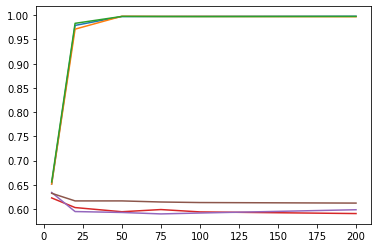

In [53]:
plt.plot(labels, train_scoreNum)
plt.plot(labels, test_scoreNum)

In [58]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 250, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [5, 32, 59, 86, 113, 141, 168, 195, 222, 250], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [60]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.5min finished


In [61]:
rf_random.best_params_

{'n_estimators': 250,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [63]:
best_random = rf_random.best_estimator_
print("training acc: ", best_random.score(X_train, y_train))
print("testing acc: ", best_random.score(X_test, y_test))

training acc:  0.763125
testing acc:  0.662


In [76]:
# Random Forest Model
rf = RandomForestClassifier(max_depth=12, n_estimators=250, min_samples_split=5, 
                            max_features='sqrt', min_samples_leaf=1, bootstrap=True)
rf.fit(X_train, y_train)
print("training acc: ", rf.score(X_train, y_train))
print("testing acc: ", rf.score(X_test, y_test))

training acc:  0.7530833333333333
testing acc:  0.6743333333333333


In [79]:
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(selected_cols, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: xyz.mean             Importance: 0.27
Variable: xyz.absolute.deviation Importance: 0.12
Variable: xyz.standard.deviation Importance: 0.12
Variable: xyz.max.deviation    Importance: 0.12
Variable: xyz.PSD.3            Importance: 0.1
Variable: xyz.PSD.10           Importance: 0.09
Variable: xyz.PSD.1            Importance: 0.07
Variable: xyz.PSD.6            Importance: 0.06
Variable: xyz.PSD.6            Importance: 0.06


[None, None, None, None, None, None, None, None, None]

In [179]:
# SVM Model and prediction
clf = SVC(gamma='auto')
clf.fit(X_train, y_train)
print("training acc: ", clf.score(X_train, y_train))
print("testing acc: ", clf.score(X_test, y_test))

training acc:  0.6420833333333333
testing acc:  0.5736666666666667


#### Train and Test on Grouped Accel Data

In [106]:
# Split features and labels
X = accel_grouped_xyz.drop(columns=['size', 'date', 'hour', 'diffSecs','PK'])
y = accel_grouped_xyz['PK']
X.shape, y.shape

((1118, 8), (1118,))

In [108]:
# Split train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_test.shape, y_test.shape

((224, 8), (224,))

In [124]:
X_test.columns

Index(['xyz.mean', 'xyz.absolute.deviation', 'xyz.standard.deviation',
       'xyz.max.deviation', 'xyz.PSD.1', 'xyz.PSD.3', 'xyz.PSD.6',
       'xyz.PSD.10'],
      dtype='object')

#### Importing Compass Data

In [12]:
cmpss_names = pd.read_csv("/Users/jahnavisingh/Downloads/MJFF-binary-files mjff_cmpss.csv")
cmpss_names.shape

(199021, 18)

In [13]:
cmpss_names.head()

,Unnamed: 0,diffSecs,level,azimuth.mean,azimuth.absolute.deviation,azimuth.standard.deviation,azimuth.max.deviation,pitch.mean,pitch.absolute.deviation,pitch.standard.deviation,pitch.max.deviation,roll.mean,roll.absolute.deviation,roll.standard.deviation,roll.max.deviation,time,PK,Name
0,1,1.161,42,37.202381,0.174149,0.202940,0.397620,-19.114286,0.152381,0.192195,0.485714,-16.590477,0.156236,0.182326,0.409524,2012-01-06 15:00:01,0,APPLE
1,2,1.023,37,37.440540,0.386267,0.677619,2.740540,-19.375675,0.492768,0.820483,2.824325,-16.508108,0.260482,0.430825,1.691892,2012-01-06 15:00:02,0,APPLE
2,3,1.019,47,34.836170,1.554912,1.717175,3.163829,-22.419149,2.128565,2.781140,6.280851,-16.704256,4.245994,4.690867,7.104255,2012-01-06 15:00:03,0,APPLE
3,4,1.009,46,31.915218,2.255010,2.754046,5.284783,-31.197826,2.789225,3.175415,5.597826,-10.102174,2.372212,2.710486,4.897826,2012-01-06 15:00:04,0,APPLE
4,5,1.035,30,33.320000,1.501334,1.577636,2.680000,-29.690001,0.698667,0.827184,1.889999,-7.836667,0.892444,1.074704,2.363333,2012-01-06 15:00:05,0,APPLE


In [14]:
# Generate date/ hour for each participant
cmpss_names['date'] = pd.to_datetime(cmpss_names['time']).dt.date
cmpss_names['hour'] = pd.to_datetime(cmpss_names['time']).dt.hour
cmpss_names.shape

(199021, 20)

In [111]:
cmpss_names.groupby(['Name', 'date', 'hour']).size()

Name       date        hour
APPLE      2012-01-06  15      3553
           2012-01-08  16      3476
                       17         1
           2012-02-08  11      3503
                       12         1
                               ... 
SUNFLOWER  2012-02-09  7       1667
           2012-03-02  11      3482
SWEETPEA   2012-02-27  9       2516
           2012-03-04  11      1029
VIOLET     2012-02-06  10      3458
Length: 106, dtype: int64

In [112]:
cmpss_names['Name'].value_counts()

DAISY        38323
ORANGE       20441
MAPLE        20195
DAFODIL      19947
ORCHID       15168
SUNFLOWER    14221
PEONY        13847
LILLY        13574
APPLE        13149
ROSE         10201
CHERRY        7838
FLOX          4325
SWEETPEA      3545
VIOLET        3458
CROCUS         789
Name: Name, dtype: int64

In [15]:
cmpss_names = cmpss_names.drop(columns='Unnamed: 0')
cmpss_names = cmpss_names.groupby(['time', 'Name']).mean().reset_index()
cmpss_names.head()

,time,Name,diffSecs,level,azimuth.mean,azimuth.absolute.deviation,azimuth.standard.deviation,azimuth.max.deviation,pitch.mean,pitch.absolute.deviation,pitch.standard.deviation,pitch.max.deviation,roll.mean,roll.absolute.deviation,roll.standard.deviation,roll.max.deviation,PK,hour
0,2011-12-15 14:00:04,DAISY,0.000000,11.0,-58.920456,0.330579,0.410352,0.704545,0.312500,0.318182,0.488504,1.250000,13.250000,0.272727,0.353553,0.750000,1.0,14.0
1,2011-12-15 14:00:05,DAISY,1.015030,11.0,-58.761364,0.578512,0.651603,1.136364,0.630682,0.392562,0.489560,1.068182,13.681818,0.289256,0.323614,0.505682,1.0,14.0
2,2011-12-15 14:00:06,DAISY,1.014492,10.0,-57.974998,0.380000,0.463681,0.900000,-0.162500,0.415000,0.467039,0.775000,13.675000,0.390000,0.459959,0.762500,1.0,14.0
3,2011-12-15 14:00:07,DAISY,1.015163,10.0,-58.099998,0.225000,0.261008,0.525000,-0.012500,0.205000,0.251247,0.425000,13.493750,0.593750,0.626529,0.993750,1.0,14.0
4,2011-12-15 14:00:08,DAISY,1.014748,11.0,-58.556820,0.177686,0.215610,0.431818,0.471591,0.446281,0.503090,0.840909,13.704545,0.338843,0.448396,0.954545,1.0,14.0


In [16]:
cmpss_names.shape

(198868, 18)

In [17]:
accel_w_names = accel_w_names.groupby(['time', 'Name']).mean().reset_index()
accel_w_names.shape

(220052, 39)

In [18]:
accel_w_names.head()

,time,Name,Unnamed: 0,diffSecs,N.samples,x.mean,x.absolute.deviation,x.standard.deviation,x.max.deviation,x.PSD.1,...,PK,xyz.mean,xyz.absolute.deviation,xyz.standard.deviation,xyz.max.deviation,xyz.PSD.1,xyz.PSD.3,xyz.PSD.6,xyz.PSD.10,hour
0,2011-11-03 08:02:26,DAISEY,41753.0,0.000000,99.0,9.903772,0.159154,0.185386,0.362564,3.520726,...,0.0,6.180365,0.126517,0.151485,0.343354,6.277292,4.931743,7.420657,1.267326,17.0
1,2011-11-03 08:02:27,DAISEY,41754.5,0.994998,98.5,9.829614,0.233962,0.307578,0.674187,0.058854,...,0.0,6.124619,0.171164,0.221686,0.492648,0.505982,6.997668,20.732017,0.724983,17.0
2,2011-11-03 08:02:28,DAISEY,41756.0,1.000017,88.0,9.921137,0.227617,0.275905,0.843194,0.432191,...,0.0,6.166843,0.167506,0.206887,0.591763,0.283042,13.388200,14.924829,2.527954,17.0
3,2011-11-03 08:02:29,DAISEY,41757.0,0.990031,99.0,9.851149,0.103614,0.124720,0.223652,0.989547,...,0.0,6.145123,0.087791,0.101461,0.170049,0.663507,3.824050,4.889053,0.944569,17.0
4,2011-11-03 08:02:30,DAISEY,41758.0,1.009885,81.0,9.842592,0.086213,0.108072,0.227479,0.009281,...,0.0,6.122150,0.083650,0.099697,0.211452,0.867265,1.710161,2.952923,0.685707,17.0


In [19]:
cmpss_names.head()

,time,Name,diffSecs,level,azimuth.mean,azimuth.absolute.deviation,azimuth.standard.deviation,azimuth.max.deviation,pitch.mean,pitch.absolute.deviation,pitch.standard.deviation,pitch.max.deviation,roll.mean,roll.absolute.deviation,roll.standard.deviation,roll.max.deviation,PK,hour
0,2011-12-15 14:00:04,DAISY,0.000000,11.0,-58.920456,0.330579,0.410352,0.704545,0.312500,0.318182,0.488504,1.250000,13.250000,0.272727,0.353553,0.750000,1.0,14.0
1,2011-12-15 14:00:05,DAISY,1.015030,11.0,-58.761364,0.578512,0.651603,1.136364,0.630682,0.392562,0.489560,1.068182,13.681818,0.289256,0.323614,0.505682,1.0,14.0
2,2011-12-15 14:00:06,DAISY,1.014492,10.0,-57.974998,0.380000,0.463681,0.900000,-0.162500,0.415000,0.467039,0.775000,13.675000,0.390000,0.459959,0.762500,1.0,14.0
3,2011-12-15 14:00:07,DAISY,1.015163,10.0,-58.099998,0.225000,0.261008,0.525000,-0.012500,0.205000,0.251247,0.425000,13.493750,0.593750,0.626529,0.993750,1.0,14.0
4,2011-12-15 14:00:08,DAISY,1.014748,11.0,-58.556820,0.177686,0.215610,0.431818,0.471591,0.446281,0.503090,0.840909,13.704545,0.338843,0.448396,0.954545,1.0,14.0


#### Merge Compass and Accel Data

In [20]:
accel_cmpss_names = accel_w_names.merge(cmpss_names, left_on=['time', 'Name'], right_on=['time', 'Name'], how='left')
accel_cmpss_names.shape

(220052, 55)

In [21]:
# Drop null values
accel_cmpss_names = accel_cmpss_names.dropna(how='any')
accel_cmpss_names.shape

(194135, 55)

In [22]:
accel_cmpss_names = accel_cmpss_names.drop(columns='Unnamed: 0')
accel_cmpss_names.columns

Index(['time', 'Name', 'diffSecs_x', 'N.samples', 'x.mean',
       'x.absolute.deviation', 'x.standard.deviation', 'x.max.deviation',
       'x.PSD.1', 'x.PSD.3', 'x.PSD.6', 'x.PSD.10', 'y.mean',
       'y.absolute.deviation', 'y.standard.deviation', 'y.max.deviation',
       'y.PSD.1', 'y.PSD.3', 'y.PSD.6', 'y.PSD.10', 'z.mean',
       'z.absolute.deviation', 'z.standard.deviation', 'z.max.deviation',
       'z.PSD.1', 'z.PSD.3', 'z.PSD.6', 'z.PSD.10', 'PK_x', 'xyz.mean',
       'xyz.absolute.deviation', 'xyz.standard.deviation', 'xyz.max.deviation',
       'xyz.PSD.1', 'xyz.PSD.3', 'xyz.PSD.6', 'xyz.PSD.10', 'hour_x',
       'diffSecs_y', 'level', 'azimuth.mean', 'azimuth.absolute.deviation',
       'azimuth.standard.deviation', 'azimuth.max.deviation', 'pitch.mean',
       'pitch.absolute.deviation', 'pitch.standard.deviation',
       'pitch.max.deviation', 'roll.mean', 'roll.absolute.deviation',
       'roll.standard.deviation', 'roll.max.deviation', 'PK_y', 'hour_y'],
      dtype=

#### Train on Accel and Compass Data

In [67]:
# selected_cmpss_cols = ['azimuth.mean', 'azimuth.absolute.deviation', 'pitch.mean',
#                        'azimuth.standard.deviation', 'azimuth.max.deviation', 
#                        'pitch.absolute.deviation', 'pitch.standard.deviation', 
#                        'pitch.max.deviation', 'roll.mean', 'roll.absolute.deviation',
#                        'roll.standard.deviation', 'roll.max.deviation']
selected_cmpss_cols = ['roll.mean', 'azimuth.mean', 'pitch.mean']
accel_cmpss_names_sample = accel_cmpss_names#.sample(10000)
X = accel_cmpss_names_sample[selected_cols + selected_cmpss_cols]
y = accel_cmpss_names_sample['PK_y']
X.shape, y.shape

((194135, 11), (194135,))

In [68]:
# Split train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_test.shape, y_test.shape

((38827, 11), (38827,))

In [30]:
# SVM Model and prediction
clf = SVC(gamma='auto')
clf.fit(X_train, y_train)
print("training acc: ", clf.score(X_train, y_train))
print("testing acc: ", clf.score(X_test, y_test))

training acc:  0.994125
testing acc:  0.8625


In [69]:
# Random Forest Model
rf3 = RandomForestClassifier(max_depth=12, n_estimators=250, min_samples_split=5, 
                            max_features='sqrt', min_samples_leaf=1, bootstrap=True)
rf3.fit(X_train, y_train)
print("training acc: ", rf3.score(X_train, y_train))
print("testing acc: ", rf3.score(X_test, y_test))

training acc:  0.9197594457465166
testing acc:  0.9097792773070286


In [60]:
# Load model
pkl_filename = "accel_compass_rf_10_29_PM.pkl"
with open(pkl_filename, 'rb') as file:
    rf3 = pickle.load(file)

In [70]:
importances = list(rf3.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(selected_cols + selected_cmpss_cols, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: roll.mean            Importance: 0.29
Variable: azimuth.mean         Importance: 0.23
Variable: xyz.mean             Importance: 0.15
Variable: pitch.mean           Importance: 0.12
Variable: xyz.absolute.deviation Importance: 0.04
Variable: xyz.standard.deviation Importance: 0.04
Variable: xyz.max.deviation    Importance: 0.04
Variable: xyz.PSD.3            Importance: 0.03
Variable: xyz.PSD.10           Importance: 0.03
Variable: xyz.PSD.6            Importance: 0.02
Variable: xyz.PSD.1            Importance: 0.01


[None, None, None, None, None, None, None, None, None, None, None]

In [71]:
# Save File
pkl_filename = "accel_compass_rf_10_07_AM.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(rf3, file)

#### Comparing Models

In [32]:
training_acc = [0.6420833333333333, 0.994125, 0.7530833333333333, 0.9037911762433358]
testing_acc = [0.5736666666666667, 0.8625, 0.6743333333333333, 0.8932186365158267]
labels = ['SVM Accel', 'SVM Accel & Compass', 'RFC Accel', 'RFC Accel & Compass']

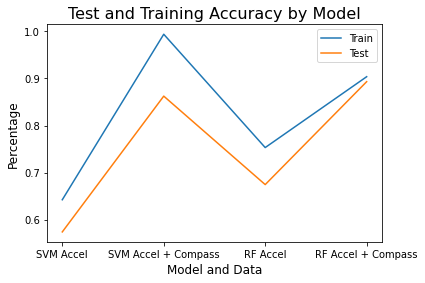

In [47]:
plt.plot(np.arange(len(training_acc)),training_acc, label='Train')
plt.plot(np.arange(len(training_acc)), testing_acc, label='Test')
plt.xlabel("Model and Data", fontsize=12)
plt.ylabel("Percentage", fontsize=12)
plt.xticks(np.arange(len(training_acc)), labels)
plt.title("Test and Training Accuracy by Model", fontsize=16)
plt.legend();
plt.savefig("model_acc.png")

#### Loading Audio Data

In [62]:
audio_names = pd.read_csv("/Users/jahnavisingh/Downloads/MJFF-binary-files mjff_audio.csv")
audio_names.head()

,Unnamed: 0,diffSecs,absolute.deviation,standard.deviation,max.deviation,PSD.250,PSD.500,PSD.1000,PSD.2000,MFCC.1,...,MFCC.6,MFCC.7,MFCC.8,MFCC.9,MFCC.10,MFCC.11,MFCC.12,time,PK,Name
0,1,0.891,26.106501,27.084455,59,1.651106e+06,3.919477e+05,9.549716e+04,5.255039e+04,74.827286,...,1.201365,-0.829399,1.180294,-0.409925,1.796904,-0.285190,0.930470,2012-01-06 15:00:00,0,APPLE
1,2,0.822,33.013626,43.112453,456,1.851591e+07,9.462458e+06,2.136161e+06,1.610672e+06,87.917053,...,-1.063456,-1.465901,1.093716,0.608562,1.269799,-1.025924,1.117749,2012-01-06 15:00:01,0,APPLE
2,3,1.020,134.760880,224.657928,2877,4.325031e+08,2.378675e+08,1.274294e+08,8.403846e+07,104.959564,...,0.172088,-0.882312,-0.982620,-0.284518,2.985557,-1.638604,1.430960,2012-01-06 15:00:02,0,APPLE
3,4,1.027,78.788750,139.422302,1567,6.607230e+07,3.535120e+07,1.984578e+07,6.437387e+06,94.775658,...,1.156372,0.528949,0.380151,-1.150360,1.521187,0.183205,1.839800,2012-01-06 15:00:03,0,APPLE
4,5,1.025,296.764008,446.447571,2968,2.087704e+09,2.310183e+09,1.585240e+09,6.257503e+08,114.526474,...,0.774541,-0.709225,0.835148,-0.106830,1.645333,-1.079758,-0.667073,2012-01-06 15:00:04,0,APPLE


In [75]:
# Drop unnecessary col
audio_names = audio_names.drop(columns=['Unnamed: 0', 'MFCC.1', 'MFCC.2', 'MFCC.3', 'MFCC.4', 
                                        'MFCC.5', 'MFCC.6', 'MFCC.7', 'MFCC.8', 'MFCC.9',
                                        'MFCC.10', 'MFCC.11', 'MFCC.12'])
audio_names.head()

,diffSecs,absolute.deviation,standard.deviation,max.deviation,PSD.250,PSD.500,PSD.1000,PSD.2000,time,PK,Name
0,0.891,26.106501,27.084455,59,1.651106e+06,3.919477e+05,9.549716e+04,5.255039e+04,2012-01-06 15:00:00,0,APPLE
1,0.822,33.013626,43.112453,456,1.851591e+07,9.462458e+06,2.136161e+06,1.610672e+06,2012-01-06 15:00:01,0,APPLE
2,1.020,134.760880,224.657928,2877,4.325031e+08,2.378675e+08,1.274294e+08,8.403846e+07,2012-01-06 15:00:02,0,APPLE
3,1.027,78.788750,139.422302,1567,6.607230e+07,3.535120e+07,1.984578e+07,6.437387e+06,2012-01-06 15:00:03,0,APPLE
4,1.025,296.764008,446.447571,2968,2.087704e+09,2.310183e+09,1.585240e+09,6.257503e+08,2012-01-06 15:00:04,0,APPLE


In [78]:
# Generate date/ hour for each participant
audio_names['date'] = pd.to_datetime(audio_names['time']).dt.date
audio_names['hour'] = pd.to_datetime(audio_names['time']).dt.hour
audio_names.shape

(242240, 13)

In [116]:
audio_names_grped = audio_names.groupby(['Name', 'date', 'hour']).mean().reset_index()
audio_names_grped.head()

,Name,date,hour,diffSecs,absolute.deviation,standard.deviation,max.deviation,PSD.250,PSD.500,PSD.1000,PSD.2000,PK
0,APPLE,2012-01-06,15,1.000070,91.565814,152.161313,1582.030564,8.801720e+08,5.879252e+08,3.407044e+08,2.070283e+08,0.0
1,APPLE,2012-01-06,16,1.024000,26.468250,26.802887,45.000000,2.438746e+05,8.491706e+04,5.967941e+04,4.227522e+04,0.0
2,APPLE,2012-01-08,16,0.999772,272.423888,448.279718,4748.034444,8.116192e+09,6.527360e+09,3.275997e+09,1.451787e+09,0.0
3,APPLE,2012-02-08,11,0.999952,72.721296,110.731785,1173.274167,1.673499e+08,5.867564e+08,2.127600e+08,1.021685e+08,0.0
4,APPLE,2012-02-18,12,1.000162,359.774676,475.966371,2469.294401,2.805590e+09,3.809235e+09,2.987581e+09,2.701719e+08,0.0


Text(0.5, 1.0, 'Standard Deviation by Hour')

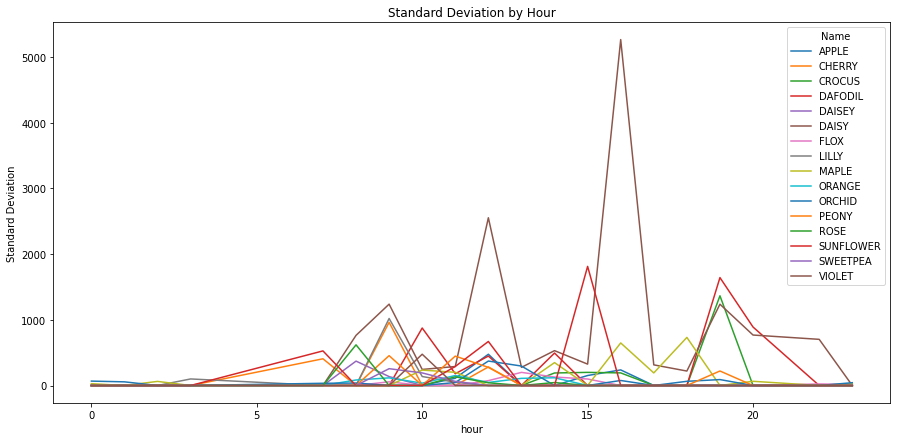

In [124]:
fig, ax = plt.subplots(figsize=(15,7))
audio_names_grped.groupby(['hour', 'Name']).mean()['standard.deviation'].unstack().fillna(0).plot(ax=ax)
plt.ylabel("Standard Deviation")
plt.title("Standard Deviation by Hour")

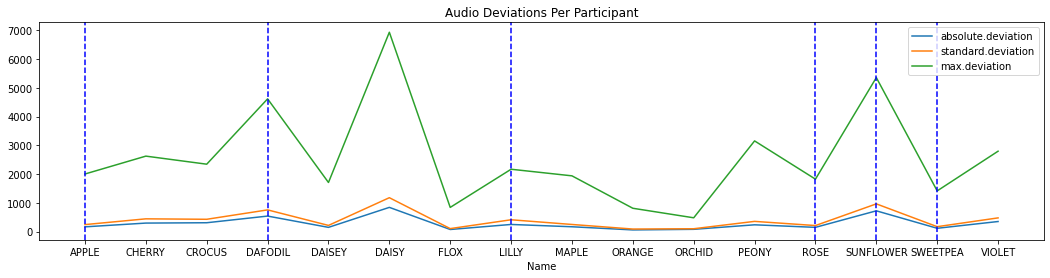

In [307]:
fig, ax = plt.subplots(figsize=(18,4))
audio_labels = ['APPLE', 'CHERRY', 'CROCUS', 'DAFODIL', 'DAISEY', 'DAISY', 'FLOX',
       'LILLY', 'MAPLE', 'ORANGE', 'ORCHID', 'PEONY', 'ROSE', 'SUNFLOWER',
       'SWEETPEA', 'VIOLET']
audio_names_grped.groupby(['Name'])[['absolute.deviation', 'standard.deviation', 'max.deviation']].mean().plot(ax=ax)
plt.xticks(np.arange(len(audio_labels)), audio_labels)
ax.axvline(0, c='b', ls='--', label='Control')
ax.axvline(3, c='b', ls='--', label='Control')
ax.axvline(7, c='b', ls='--', label='Control')
ax.axvline(12, c='b', ls='--', label='Control')
ax.axvline(13, c='b', ls='--', label='Control')
ax.axvline(14, c='b', ls='--', label='Control')
plt.title("Audio Deviations Per Participant");

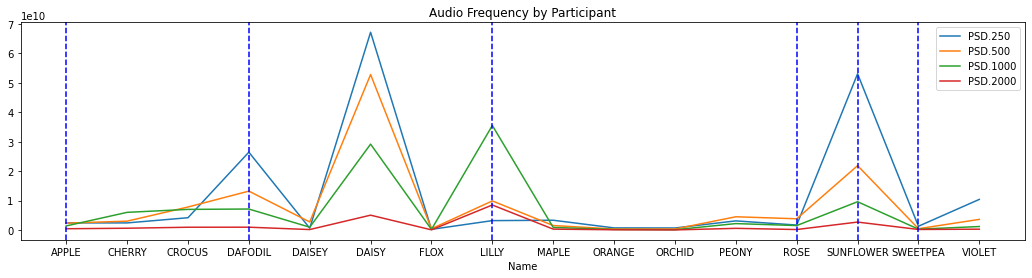

In [306]:
fig, ax = plt.subplots(figsize=(18,4))
audio_labels = ['APPLE', 'CHERRY', 'CROCUS', 'DAFODIL', 'DAISEY', 'DAISY', 'FLOX',
       'LILLY', 'MAPLE', 'ORANGE', 'ORCHID', 'PEONY', 'ROSE', 'SUNFLOWER',
       'SWEETPEA', 'VIOLET']
audio_names_grped.groupby(['Name'])[['PSD.250', 'PSD.500', 'PSD.1000', 'PSD.2000']
                                   ].mean().plot(ax=ax)
plt.xticks(np.arange(len(audio_labels)), audio_labels)
ax.axvline(0, c='b', ls='--', label='Control')
ax.axvline(3, c='b', ls='--', label='Control')
ax.axvline(7, c='b', ls='--', label='Control')
ax.axvline(12, c='b', ls='--', label='Control')
ax.axvline(13, c='b', ls='--', label='Control')
ax.axvline(14, c='b', ls='--', label='Control')
plt.title("Audio Frequency by Participant");

In [107]:
audio_names_grped.groupby('Name')['date'].apply(lambda x: print(x))

0    2012-01-06
1    2012-01-08
2    2012-02-08
3    2012-02-18
Name: APPLE, dtype: object
4    2012-01-24
5    2012-01-28
6    2012-02-03
7    2012-02-10
8    2012-02-11
Name: CHERRY, dtype: object
9     2012-01-17
10    2012-01-18
11    2012-01-25
Name: CROCUS, dtype: object
12    2012-01-12
13    2012-01-15
14    2012-01-17
15    2012-01-19
16    2012-01-21
17    2012-02-03
18    2012-02-20
Name: DAFODIL, dtype: object
19    2011-11-03
20    2011-11-04
Name: DAISEY, dtype: object
21    2011-11-30
22    2011-12-15
23    2011-12-23
24    2012-01-01
25    2012-01-02
26    2012-01-04
27    2012-01-11
28    2012-01-14
29    2012-01-16
30    2012-01-19
31    2012-01-21
32    2012-01-23
33    2012-01-25
34    2012-01-26
35    2012-01-29
36    2012-02-03
37    2012-02-08
38    2012-02-11
Name: DAISY, dtype: object
39    2011-12-11
40    2011-12-13
41    2011-12-14
42    2011-12-23
43    2012-01-04
44    2012-01-13
45    2012-01-23
46    2012-02-03
Name: FLOX, dtype: object
47    2011-12-29


Name
APPLE        None
CHERRY       None
CROCUS       None
DAFODIL      None
DAISEY       None
DAISY        None
FLOX         None
LILLY        None
MAPLE        None
ORANGE       None
ORCHID       None
PEONY        None
ROSE         None
SUNFLOWER    None
SWEETPEA     None
VIOLET       None
Name: date, dtype: object

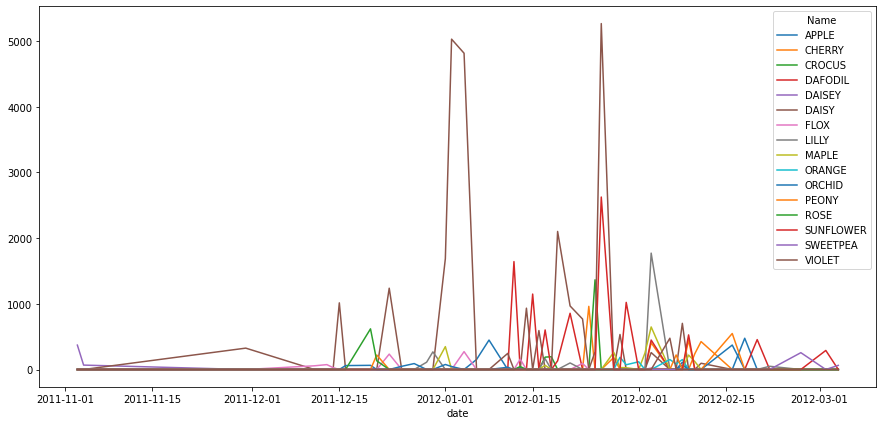

In [103]:
fig, ax = plt.subplots(figsize=(15,7))
audio_names_grped.groupby(['date', 'Name']).mean()['standard.deviation'].unstack().fillna(0).plot(ax=ax)

No handles with labels found to put in legend.


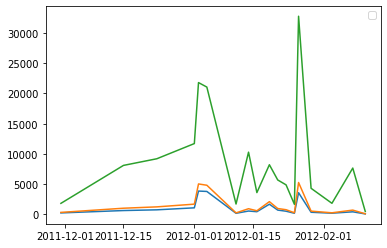

In [115]:
audio_daisy = audio_names_grped[audio_names_grped['Name'] == 'DAISY'][['date','absolute.deviation', 'standard.deviation', 'max.deviation']]
plt.plot(audio_daisy['date'], audio_daisy.drop(columns='date'))
plt.legend()

#### Loading GPS Data 

In [125]:
gps_names = pd.read_csv('/Users/jahnavisingh/Downloads/MJFF-binary-files mjff_gps.csv')
gps_names.shape

(127380, 8)

In [127]:
gps_names = gps_names.drop(columns='Unnamed: 0')
gps_names.head()

,diffSecs,latitude,longitude,altitude,time,PK,Name
0,1.111,42.881755,-71.553012,74.099998,2012-02-08 11:00:01,0,APPLE
1,1.018,42.881755,-71.553011,74.099998,2012-02-08 11:00:02,0,APPLE
2,0.735,42.881755,-71.553011,74.099998,2012-02-08 11:00:02,0,APPLE
3,0.348,42.881755,-71.553012,74.099998,2012-02-08 11:00:03,0,APPLE
4,0.992,42.881755,-71.553011,74.099998,2012-02-08 11:00:04,0,APPLE


In [128]:
# Generate date/ hour for each participant
gps_names['date'] = pd.to_datetime(gps_names['time']).dt.date
gps_names['hour'] = pd.to_datetime(gps_names['time']).dt.hour
gps_names.shape

(127380, 9)

In [165]:
gps_names[(gps_names['Name'] == 'DAISY') & (gps_names['time'].str.contains('2012-01-19'))]['longitude'].unique()

array([-114.73944604, -112.43312716, -112.72298813, -112.4035424 ,
       -111.48110926, -112.35076189, -111.01027966, -111.49722397,
       -110.94395936, -110.93500078, -110.9660393 , -110.97305596,
       -110.95527828, -110.94347119, -110.84889114, -111.00916922,
       -110.29013872, -110.79673827, -110.78028023, -110.9962517 ,
       -110.80763876, -110.36249936, -110.96777737, -109.59479213,
       -109.75520968, -110.18708289, -108.25861216, -108.41527998,
       -110.21201134, -108.13861012, -106.87777877, -107.7824986 ,
       -106.76694453, -106.62472308, -108.01083505, -106.05916858,
       -106.8131268 , -106.77180469, -107.09257007, -106.58513904,
       -107.09250033, -106.76861286, -106.36562705, -106.36999905,
       -106.36770844, -105.96416473, -106.41396046, -106.20437264,
       -106.49888992, -106.34798348, -106.51048779, -106.3034749 ,
       -106.39618278, -106.1954838 , -103.25729012, -103.17944705,
       -103.13694477, -104.43861008, -104.51527834, -104.39694

In [196]:
# Function to compute distance between each point in the group
def get_dist(x):
    pts = list(zip(x['latitude'].tolist(), x['longitude'].tolist()))
    pair_pts = list(zip(pts[::1], pts[1:]))
    return sum([vincenty(p[0], p[1]).miles for p in pair_pts])
    
gps_dist = gps_names.groupby(['Name', 'date', 'hour']).apply(get_dist).reset_index().rename({0:'Distance'}, axis=1)

/Users/jahnavisingh/anaconda3/envs/PH244/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


Text(0.5, 1.0, 'Average Distance Moved by Hour')

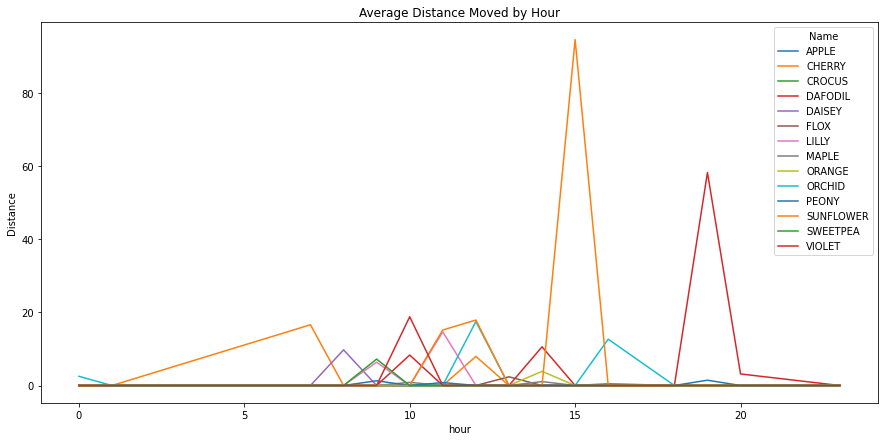

In [197]:
fig, ax = plt.subplots(figsize=(15,7))
gps_dist[gps_dist['Name'] != "DAISY"].groupby(['hour', 'Name']).mean()['Distance'].unstack().fillna(0).plot(ax=ax)
plt.ylabel("Distance")
plt.title("Average Distance Moved by Hour")

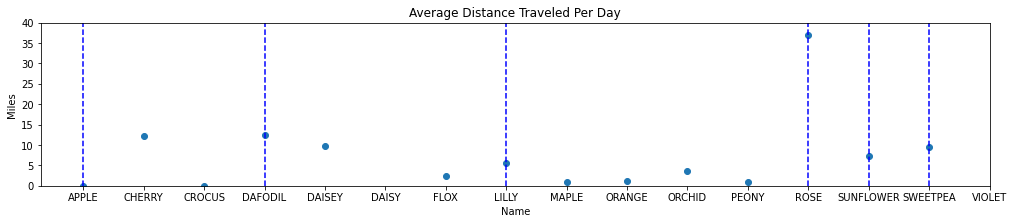

In [304]:
fig, ax = plt.subplots(figsize=(17,3))
gps_dist.groupby(['Name'])['Distance'].mean().plot(style='o', ax=ax)
plt.ylabel('Miles')
plt.xticks(np.arange(len(audio_labels)), audio_labels)
plt.ylim(0,40)
ax.axvline(0, c='b', ls='--', label='Control')
ax.axvline(3, c='b', ls='--', label='Control')
ax.axvline(7, c='b', ls='--', label='Control')
ax.axvline(12, c='b', ls='--', label='Control')
ax.axvline(13, c='b', ls='--', label='Control')
ax.axvline(14, c='b', ls='--', label='Control')
plt.title('Average Distance Traveled Per Day');

In [266]:
gps_names = gps_names.round({'longitude':2, 'latitude':2})
home_addr = gps_names.groupby('Name')[['longitude', 'latitude']].agg(pd.Series.mode).reset_index()
# Make sure only 1 latitude and logitude pair
def get_first(x):
    if isinstance(x, np.ndarray):
        return x[0]
    return x
home_addr['latitude'] = home_addr['latitude'].apply(get_first)
home_addr['longitude'] = home_addr['longitude'].apply(get_first)

In [267]:
home_addr

,Name,longitude,latitude
0,APPLE,-71.55,42.88
1,CHERRY,-118.06,33.80
2,CROCUS,-71.49,42.86
3,DAFODIL,-71.04,42.34
4,DAISEY,-71.23,42.32
5,DAISY,-71.91,44.36
6,FLOX,-70.97,42.38
7,LILLY,-71.00,42.37
8,MAPLE,-72.55,42.60
9,ORANGE,-118.19,33.77
